# 4 and 6 hour data analysis & Plotting

## From the 24 hour sequencing data

Environment for this code to run in: 24hr_env
The .yml file with the dependencies is /Users/berelsom/Documents/Bioinformatics/24hr_environment.yml 

Can then use this environment as the kernel and all the packages should work

Looking at the MARTi & PHIbase taxonomic assignments 

Notes on the output and plans here https://docs.google.com/document/d/1G7dcuGI-hXJssUwlVugpkle_YsmQoMl6apiegQlSPgA/edit#heading=h.pu4kwymrkqzk

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
import datetime as dt
import numpy as np

import scipy
from sklearn.cluster import AgglomerativeClustering

from scipy.stats import entropy

# Reading in the data

## MARTi
Note - here I have been using the assigned counts. This is okay because I have the lineage data I can select all rows where the Phylum == Ascomycota and it will select all the taxonomic levels below also. 

In [14]:
read_count = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/marti_assigned_read_count_24hrCub.csv")
meta = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/24hr_Cub_meta.csv")
lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/24hrCub_taxaIDs_lineage_sep.csv")

Reformatting the meta data, don't need to repeat this step can use the CSV file I saved the output as:
/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/24hrCub_combined_read_data
Will need repeating if the samples are run through MARTi again

In [19]:
# #Make empty Sample column negative control 
# meta['Sample'] = meta['Sample'].replace('', 'negative')

# #convert date into date format
# meta["Date_collected"] = pd.to_datetime(meta["Date_collected"])

# # Separate negative control
# negative_control = meta[meta['Sample'] == 'Negative']
# meta = meta[meta['Sample'] != 'Negative']

# #Make a col for start
# meta["Start"] = meta["Sample"].str.split('_').str[1]
# meta["Start"] = pd.to_datetime(meta["Start"]).dt.time
# meta["Start"] = pd.to_datetime(meta["Date_collected"].dt.date.astype(str) + " " + meta["Start"].astype(str)) #Add date to start time

# # #Calculate end time
# meta["End"] = meta["Start"] + pd.to_timedelta(meta["Time_hrs"], unit='h')


# # #Calculate mid point
# meta["Mid"] = meta["Start"] + (pd.to_timedelta(meta["Time_hrs"], unit='h')/2)

# # Rejoin the negative control
# meta = pd.concat([meta, negative_control])

# #Melt the data to long
# read_count = read_count.melt(
#     id_vars = ['Taxon', 'NCBI ID'],           # the columns we want to keep
#     var_name = 'Sample',    # the name of the new column with old column names (to contain the cols we are combining)
#     value_name = 'read count' # the name of the new column with old column values
# )

# #Add lineage data and merge on NCBI ID
# read_count_lin = read_count.merge(lineage, how='right')

# #Add metadata and merge on sample
# read_lin_meta = read_count_lin.merge(meta, how='right')

# #Create column for relative abundance
# read_lin_meta["rel_abundance"] = (read_lin_meta["read count"] / read_lin_meta["Basecalled_reads"]) * 100

# #Edit Oomycota class from unassigned to Oomycota
# read_lin_meta.loc[
#     (read_lin_meta["Phylum"] == 'Oomycota') & (read_lin_meta["Class"].str.contains('Unassigned')),
#     "Class"
# ] = "Oomycota"

# # Specify the file path where you want to save the CSV file
# file_path = "/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/24hrCub_combined_marti_read_data"

# # Write the DataFrame to a CSV file
# read_lin_meta.to_csv(file_path, index=False)

## PHIbase

In [20]:
# phibase = pd.read_csv(
#     "/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/PHIbase_24hr_analysis/PHIbase_24hr_taxaID_count.tsv",
#     delimiter="\t", 
#     names=["taxid", "Count", "Barcode"])

# lineage_phi = pd.read_csv(
#     "/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/PHIbase_24hr_analysis/PHIbase_24hr_taxaID_lineage_sep_head.csv").drop_duplicates()

# phi_lin = phibase.merge(lineage_phi, how='right')

# phi_lin_meta = phi_lin.merge(meta, how='right')
# phi_lin_meta["rel_abundance"] = (phi_lin_meta["Count"] / phi_lin_meta["Basecalled_reads"]) * 100

# phi_lin_meta.loc[
#     (phi_lin_meta["Phylum"] == 'Oomycota') & (phi_lin_meta["Class"].str.contains('Unassigned')),
#     "Class"
# ] = "Oomycota"

# # Specify the file path where you want to save the CSV file
# phi_file_path = "/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/24hrCub_combined_pathogen_read_data"

# # Write the DataFrame to a CSV file
# phi_lin_meta.to_csv(phi_file_path, index=False)


### Reading in the combined data 

In [4]:
read_lin_meta = pd.read_csv(
    "/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/24hrCub_combined_marti_read_data"
    )

phi_lin_meta = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/24hrCub_combined_pathogen_read_data"
    )

# ***Plotting***

-Filter to only include the Fungi samples & 4/6hrs, samples greater than 0.1%

-Plot 4 and 6 hour samples on their own axis

In [12]:
fungi_phyla = ["Ascomycota", "Basidiomycota", "Oomycota"]

fungi_ph = read_lin_meta[
    read_lin_meta["Phylum"].isin(fungi_phyla)&
    (read_lin_meta["rel_abundance"] > 0.1) &
    read_lin_meta["Time_hrs"].isin([4, 6])
]

Definitely looks as though the Phyla are behaving differently, now to drill down further will look at the fungi classes

In [10]:
# #Don't really need to generate classes dataset as I can sample out of the Phylum, only matters if I don't want Unassigned classes
# [fungi_ph["Class"].unique()]

# fungi_classes = [
#     'Oomycota',
#     'Tremellomycetes', 
#     'Sordariomycetes',
#     'Dothideomycetes', 
#     'Leotiomycetes',  
#     'Eurotiomycetes',
#     'Agaricomycetes',
#     'Ustilaginomycetes'
# ]

# fungi_cl = read_lin_meta[
#     read_lin_meta["Class"].isin(fungi_classes)
#     & (read_lin_meta["rel_abundance"] > 0.1)
#     & read_lin_meta["Time_hrs"].isin([4, 6])
# ]

# fungi_cl['Phylum'].unique()

In [11]:
# # Define a dictionary to map classes to colors
# class_colours = {
#     'Agaricomycetes': '#332288',
#     'Dothideomycetes': '#DDCC77',
#     'Eurotiomycetes': '#117733',
#     'Leotiomycetes': '#88CCEE',
#     'Oomycota': '#882255',
#     'Sordariomycetes': '#44AA99',
#     'Tremellomycetes': '#999933',
#     'Ustilaginomycetes': '#AA4499',
# }

# # Sort the class_colours dictionary by key in alphabetical order
# class_colours = dict(sorted(class_colours.items(), key=operator.itemgetter(0)))


# # Use the class_colors dictionary as the palette parameter
# sns.catplot(
#     data=fungi_ph[fungi_ph["Time_hrs"] == 4],
#     x="Sample",
#     y="rel_abundance",
#     kind="bar",
#     aspect=1.5,
#     hue="Class",
#     hue_order=class_colours.keys(),
#     palette=class_colours,
#     # col = "Phylum",
#     # col_wrap =1
# )
# plt.title("Fungal classes in the air at 4 hour intervals")

In [12]:

# sns.catplot(
#     data=fungi_ph[fungi_ph["Time_hrs"] == 6],
#     x="Sample",
#     y="rel_abundance",
#     kind="bar",
#     hue="Class",
#     hue_order=class_colours.keys(),
#     palette=class_colours,
#     aspect=1.5,
# )
# plt.title("Fungal classes in the air at 6 hour intervals")

Now want to plot each Phylum on it's own axis coloured by Genus.

In [13]:
# family = sns.catplot(
#     data=fungi_cl[fungi_cl["Time_hrs"] == 4],
#     x="Sample",
#     y="rel_abundance",
#     kind="bar",
#     hue="Family",
#     aspect=2,
#     col="Class",
#     col_wrap=4,
#     height=6,
# )


# for ax in family.axes:
#     ax.tick_params(labelbottom=True)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


Filter to get data of Fungi families and then plot these coloured by class

In [14]:
#Write a loop to generate a plot for each class
# for fungi_class in fungi_classes:
#     sns.catplot(
#         data=fungi_cl[
#             (fungi_cl["Time_hrs"] == 6) & (fungi_cl["Class"] == fungi_class)
#         ],
#         x="Sample",
#         y="rel_abundance",
#         kind="bar",
#         hue="Family",
#         aspect=1,
#     )
#     plt.title(fungi_class)
#     plt.show()


Plot top 20 fungal species as a point graph over time 

In [9]:
# Group the 'fungi_ph' dataframe by the 'Sample' column
# Filter out any unassigned species
# Sort each group by 'rel_abundance' column in descending order
# Select the top 30 rows from each group
top_15 = fungi_ph[fungi_ph['Species'] != 'Unassigned'].groupby("Sample").apply(
    lambda x: x[x['Species'] != 'Unassigned'].sort_values("rel_abundance", ascending=False).head(15)
).reset_index(drop=True)


In [16]:
# top15_4 = sns.catplot(
#     data=top_15[top_15["Time_hrs"] == 4],
#     x="Sample",
#     y="rel_abundance",
#     kind="point",
#     hue="Species",
#     height=8,
#     # col='Class',
#     # col_wrap =3,
#     aspect=1.5,  # Adjust the aspect ratio of each subplot
#     margin_titles=True,  # Add space for subplot titles
#     legend_out=True,  # Move the legend outside the plot area,
#     palette = "Set2"
# )

# # Adjust the spacing between subplots
# top15_4.fig.subplots_adjust(hspace=0.6, wspace=0.2)

# # Set the title above the plot
# top15_4.fig.suptitle("Top 15 Fungal species in the air at 4 hour intervals", y=1.05)

# for ax in top15_4.axes:
#     ax.tick_params(labelbottom=True)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


# Species

### ***4 and 6 hour same axis***

Should now be able to plot the data using the mid point and time as the x-axis.

Filtering to only contain fungi on the one day of sampling with a rel abundance >0.1

In [10]:
fungi_phyla = ["Ascomycota", "Basidiomycota", "Oomycota"]

# Commenting this out whilst working on the PHIbase data
fungi_data = read_lin_meta[
    read_lin_meta["Phylum"].isin(fungi_phyla)&
    (read_lin_meta["rel_abundance"] > 0.15) &
    read_lin_meta["Time_hrs"].isin([4, 6])&
    (read_lin_meta["Species"] != "Unassigned")
]

Filtering the data so it only contains species that are present in multiple samples.

In [11]:
# Count unique samples per species
species_sample_counts = fungi_data.groupby('Species')['Sample'].nunique()

# Filter out species present less than once
valid_species = species_sample_counts[species_sample_counts > 1].index.tolist()
print(len(valid_species))

# Filter data for valid species
filtered_data = fungi_data[fungi_data['Species'].isin(valid_species)]

## Look at relative abundance of species I am removing

invalid_species = species_sample_counts[species_sample_counts == 1].index.tolist()
# Filter data for species with only one sample occurrence
removed_species_data = fungi_data[fungi_data['Species'].isin(invalid_species)]
removed_species_relative_abundance = removed_species_data.groupby('Species')['rel_abundance'].mean()
print(removed_species_relative_abundance)


21
Species
Alternaria ethzedia          0.154916
Didymella exigua             0.153232
Macroventuria anomochaeta    0.151355
Name: rel_abundance, dtype: float64


Getting a list of species in the datat to examine in the literature

In [57]:
# species_df = pd.DataFrame(filtered_data['Species'].sort_values().unique(), columns=['Species'])

Plotting MARTi species assignments from the filtered data (species present in multiple samples) and with a relative abundance >0.15%

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

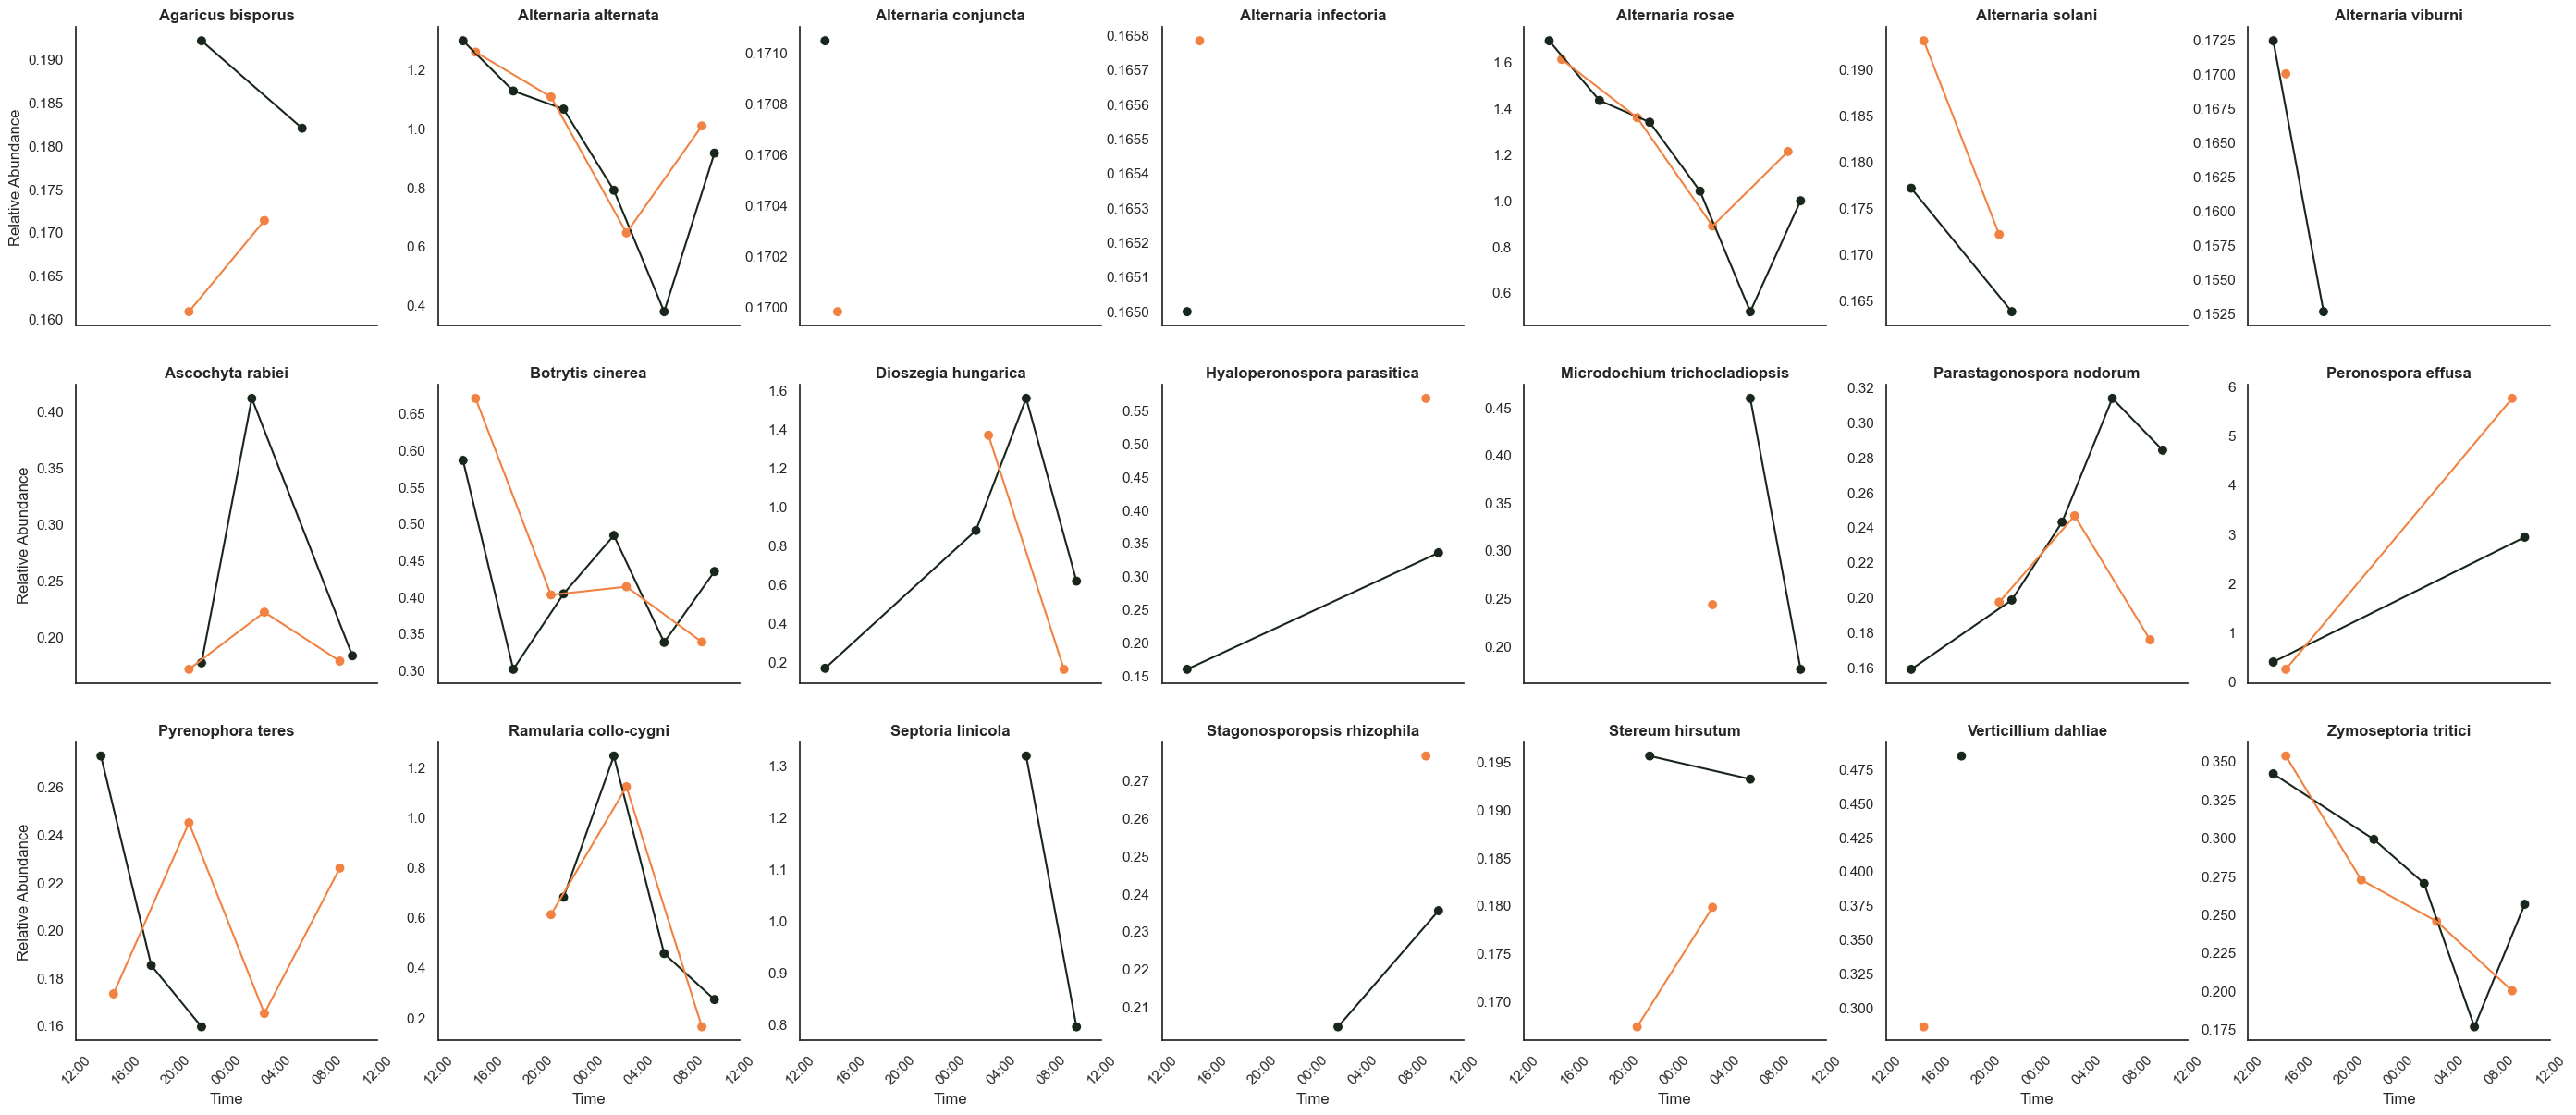

In [12]:
sns.set(font='Arial', style='white')
# Sort species alphabetically
sorted_species = filtered_data['Species'].sort_values().unique()

# Get unique Phylum values and sort them
phylum_order = filtered_data['Phylum'].unique()
phylum_order.sort()

# Get the time range of your data
min_time = filtered_data['Start'].min()
max_time = filtered_data['End'].max()

# Create a FacetGrid with scatter plots for points and line plots to connect them, faceted by species
g = sns.FacetGrid(
    filtered_data,
    col="Species",
    col_wrap=7,
    col_order=sorted_species,
    row_order=phylum_order,  # Sort rows by Phylum
    sharey=False, 
    height =4,
)

# Create scatter plots within each facet (points)
g.map_dataframe(
    sns.scatterplot,
    x="Mid",
    y="rel_abundance",
    hue="Time_hrs",
    palette={4: "#19261C", 6: "#F28241"},  # Specify hex codes for Time_hrs
    marker='o',  # Set marker as 'o' (circle)
    s=60,  # Adjust marker size as needed 
)

# Create line plots within each facet (connecting lines)
g.map_dataframe(
    sns.lineplot,
    x="Mid",
    y="rel_abundance",
    hue="Time_hrs",
    palette={4: "#19261C", 6: "#F28241"},  # Specify hex codes for Time_hrs
    legend=False,  # Hide the legend for the line plot
)

# Set x-axis properties for each subplot
g.set_axis_labels("Time", "Relative Abundance")
g.set_titles("{col_name}", fontweight = 'heavy', fontsize = 30)  # Set titles based on species

# Set x-axis properties for all subplots
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(HourLocator(interval=4))  # Set 2-hourly intervals
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Format x-axis to show hours and minutes
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Set x-axis limits from min_time to max_time
    ax.set_xlim([min_time, max_time])

# Adjust space between plots
g.figure.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust the width and height space between subplots

# Plotting PHIbase
Filtering the PHIbase data 

- fungi phyla
- at least 2 samples have a relative abundance > 0.3

In [13]:
fungi_phyla = ["Ascomycota", "Basidiomycota", "Oomycota"]

fungi_phi_data = phi_lin_meta[
    phi_lin_meta["Phylum"].isin(fungi_phyla) &
    phi_lin_meta["Time_hrs"].isin([4, 6]) &
    (phi_lin_meta["Species"] != "Unassigned")
]

# Filter the data to include species with at least one repeat having rel_abundance > 0.2
#This means all the other data from that species is retained but not looking at genera which are never present at any higher level
#checks if max value of the "rel_abundance" column within each species is greater than 0.2.
# If this condition is true, the group is included in the filtered result.
# fungi_species_filter = fungi_phi_data.groupby("Species").filter(lambda x: x["rel_abundance"].max() > 0.2)

#Instead want to include species where at least 2 samples have a rel_abundance > 0.3
fungi_species_filter = fungi_phi_data.groupby("Genus").filter(lambda x: x["rel_abundance"].nlargest(2).min() > 0.3)

#Filter the data to remove read count = 0
fungi_species_filter = fungi_species_filter[
    fungi_species_filter['Count'] != 0
]

fungi_species_filter["Species"].unique()

array(['Pyrenophora teres', 'Botrytis cinerea', 'Phytophthora infestans',
       'Phytophthora capsici', 'Curvularia lunata',
       'Heterobasidion annosum', 'Alternaria solani',
       'Alternaria brassicicola', 'Parastagonospora nodorum',
       'Bipolaris oryzae', 'Alternaria alternata', 'Bipolaris maydis',
       'Bipolaris zeicola', 'Bipolaris sorokiniana',
       'Bipolaris victoriae', 'Alternaria longipes',
       'Peronospora tabacina', 'Phytophthora cactorum',
       'Zymoseptoria tritici', 'Podosphaera aphanis', 'Ascochyta rabiei',
       'Phytophthora sojae', 'Phytophthora parasitica',
       'Pyrenophora tritici-repentis', 'Botrytis elliptica'], dtype=object)

Plotting this filtered dataset

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

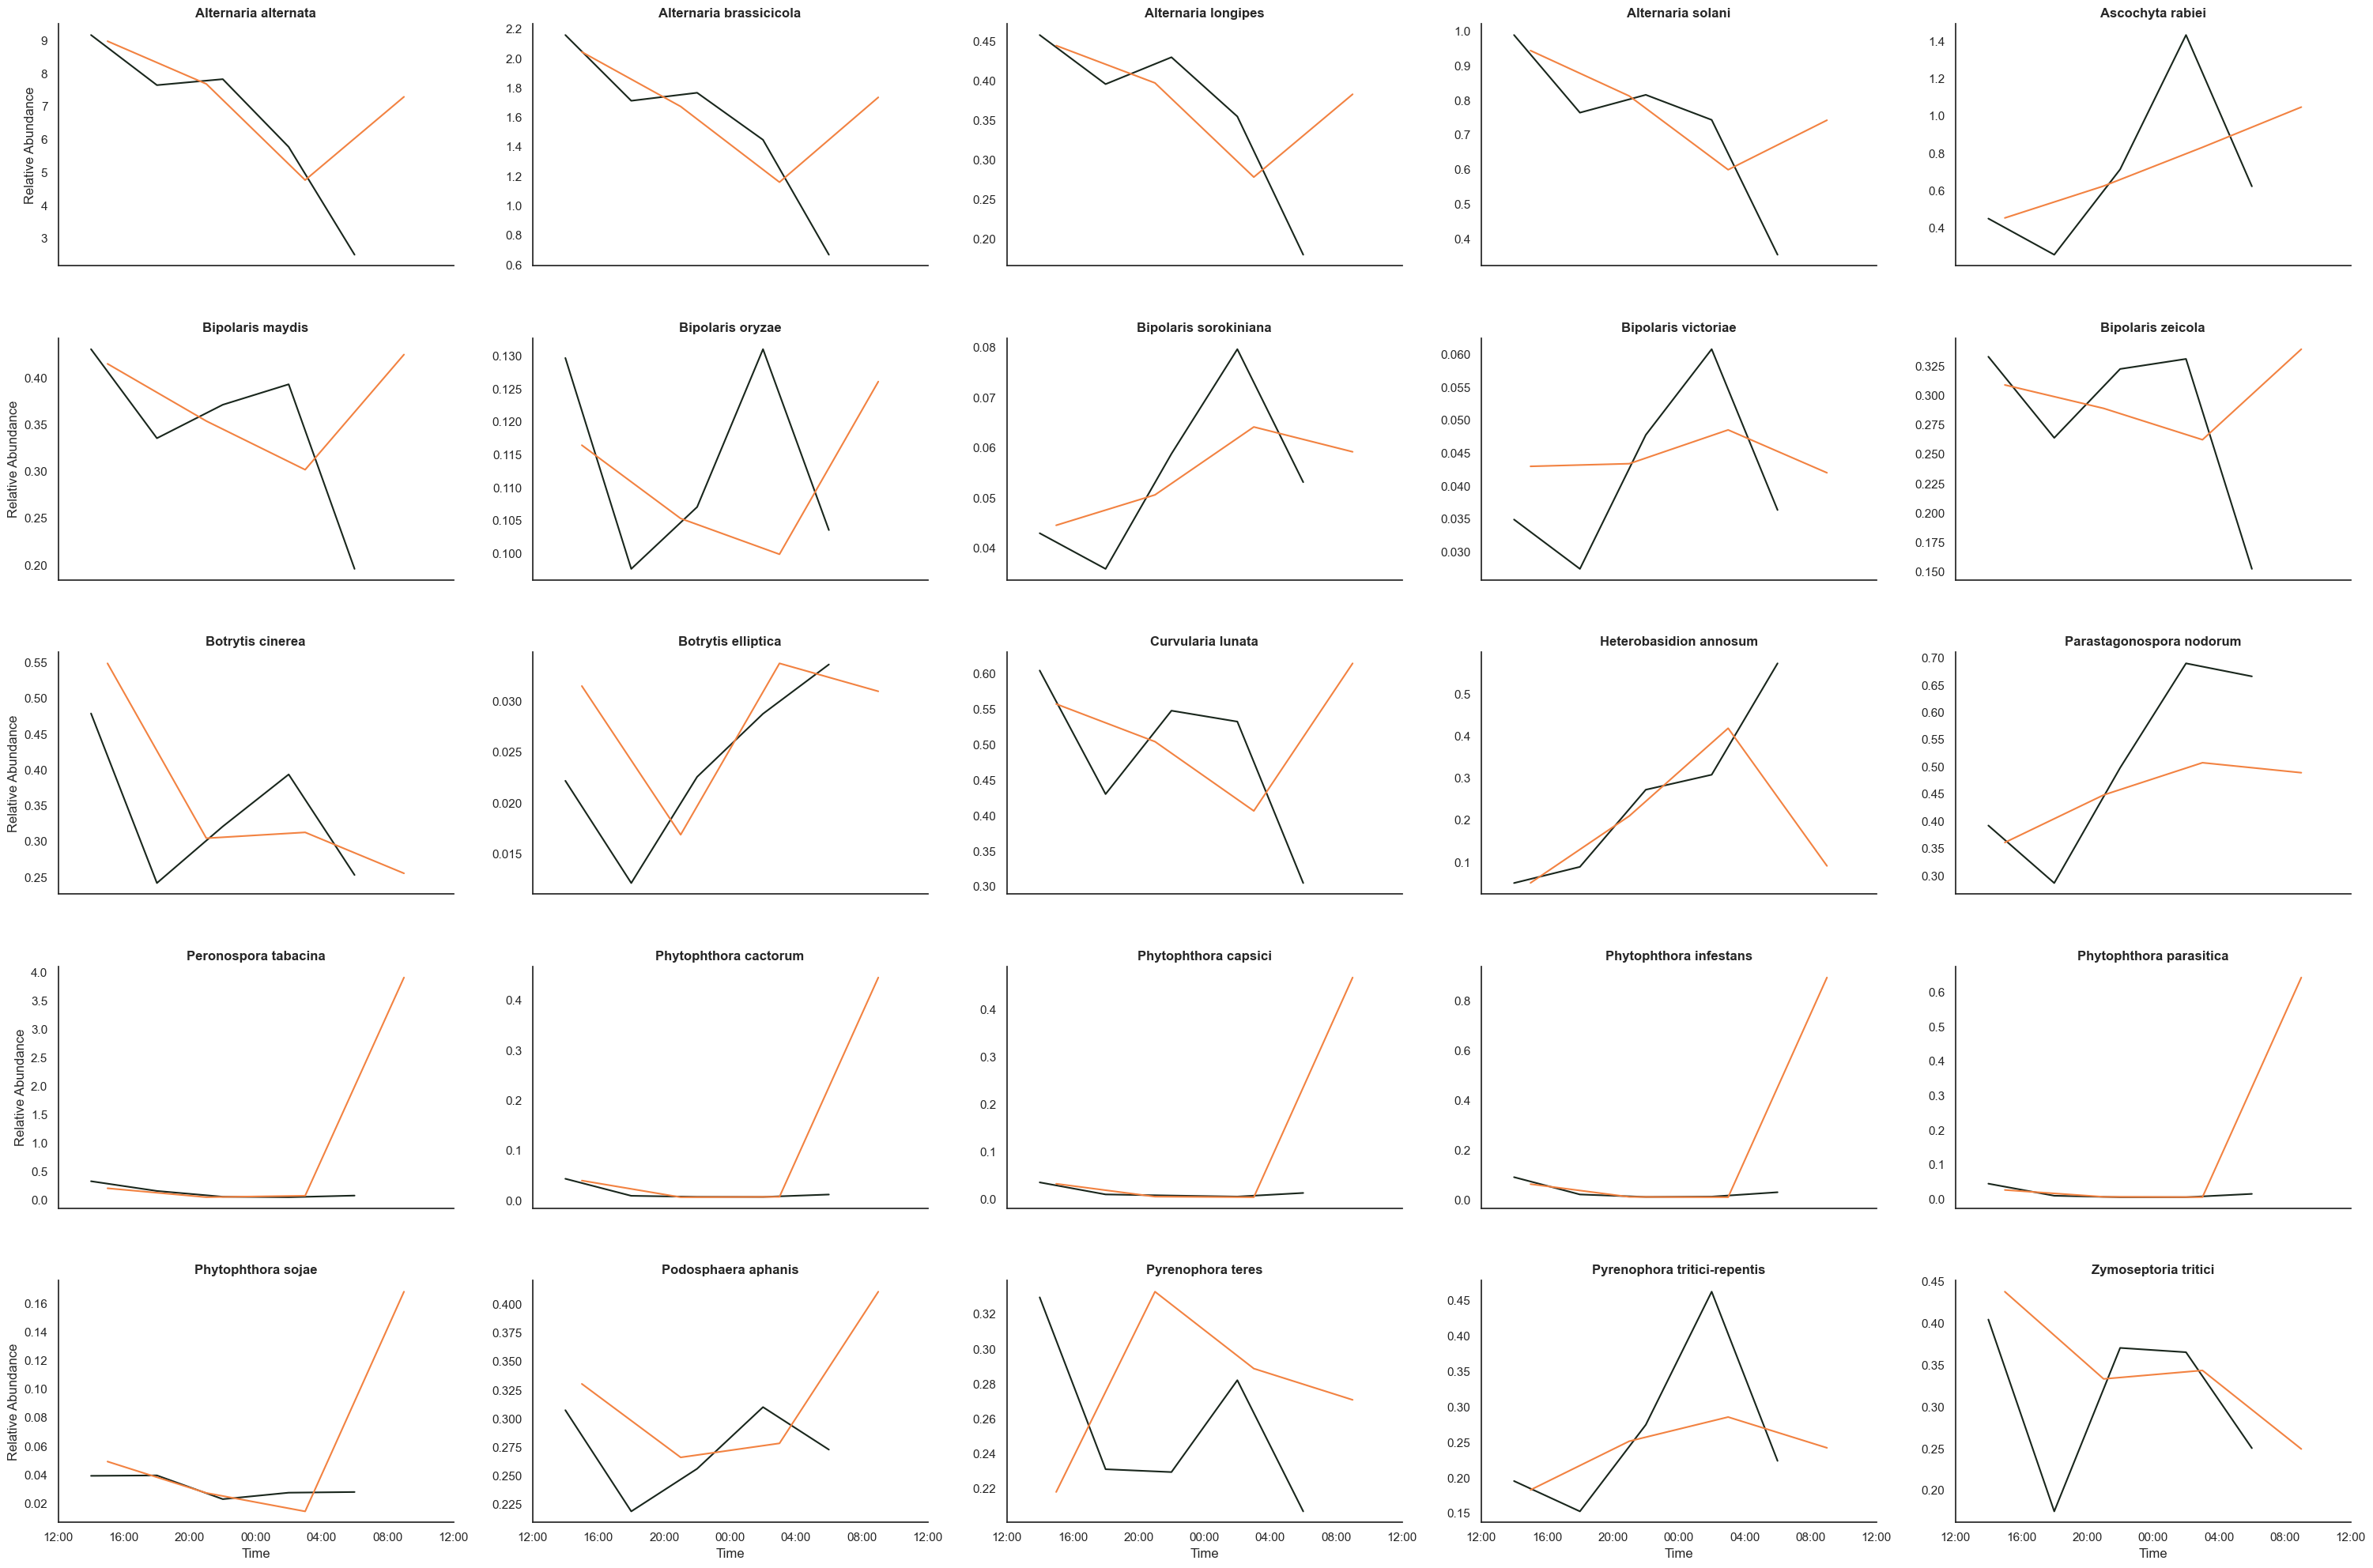

In [17]:
from datetime import datetime

sns.set(font='Arial', style='white')
# Sort species alphabetically
sorted_genus = fungi_species_filter['Species'].sort_values().unique()
#sorted_genus = fungi_species_filter['Genus'].sort_values().unique()

# Get the time range of your data
min_time = fungi_species_filter['Start'].min()
max_time = fungi_species_filter['End'].max()

# Create a FacetGrid with scatter plots for points and line plots to connect them, faceted by species / Genus
g = sns.FacetGrid(
    fungi_species_filter,
    col="Species",
    #col="Genus",
    col_wrap=5,
    col_order=sorted_genus,
    sharey=False, 
    height = 4,
    aspect = 1.5,
)

# # Create scatter plots within each facet - don't want the points so commented out
# g.map_dataframe(
#     sns.scatterplot,
#     x="Mid",
#     y="rel_abundance",
#     hue="Time_hrs",
#     palette={4: "#19261C", 6: "#F28241"},  # Specify hex codes for Time_hrs
#     marker='x',  # Set marker as 'o' (circle)
#     s=20,  # Adjust marker size as needed
# )

# Create line plots within each facet (connecting lines)
g.map_dataframe(
    sns.lineplot,
    x="Mid",
    y="rel_abundance",
    hue="Time_hrs",
    palette={4: "#19261C", 6: "#F28241"},  # Specify hex codes for Time_hrs
    legend=False,  # Hide the legend for the line plot
    # err_style="bars" #If you want bars rather than faded sections
)

# Set x-axis properties for each subplot
g.set_axis_labels("Time", "Relative Abundance")
g.set_titles("{col_name}", fontweight = 'heavy', fontsize = 50)  # Set titles based on species

# Set x-axis properties for all subplots
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(HourLocator(interval=4))  # Set 2-hourly intervals
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Format x-axis to show hours and minutes
    # ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Set x-axis limits from min_time to max_time
    ax.set_xlim([min_time, max_time])

# Adjust space between plots
g.figure.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust the width and height space between subplots

plt.figsize=(15, 10)

#This will plot the lines but they just dn't look quite right
# # Add vertical lines for 'Start' times to the plot with 'Time_hrs' equal to 4
# for line in fungi_species_filter[fungi_species_filter['Time_hrs'] == 4]['Start']:
#     g.map(plt.axvline, x=line, color='#C4C6C5', linestyle=':', alpha = 0.7)  # Change color and linestyle as needed

# # Add vertical lines for 'Start' times to the plot with 'Time_hrs' equal to 6
# for line in fungi_species_filter[fungi_species_filter['Time_hrs'] == 6]['End']:
#     g.map(plt.axvline, x=line, color='#FBDACB', linestyle=':', alpha = 0.7)  # Change color and linestyle as needed




## Plotting just the Alternaria species from the MARTi data

Filtering the data

In [15]:
# Alternaria
alternaria_data = read_lin_meta[
    (read_lin_meta["Genus"] == "Alternaria") &
    read_lin_meta["Time_hrs"].isin([4, 6]) &
    (read_lin_meta["Species"] != "Unassigned")
]

#Filter to include species where at least 1 samples have a rel_abundance > 0.15
alternaria_data = alternaria_data.groupby("Species").filter(lambda x: x["rel_abundance"].nlargest(1).min() > 0.16)


#Pick out data which seem to reflect humidity data
hum_species = ("Asccochyta", "Cuvularia", "Heterobasidion", "Parastagonospora", "Zymoseptoria")
hum_data = read_lin_meta[
    (read_lin_meta["Genus"].isin(hum_species)) &
    read_lin_meta["Time_hrs"].isin([4, 6]) &
    (read_lin_meta["Species"] != "Unassigned")
]

#Filter to include species where at least 1 samples have a rel_abundance > 0.15
hum_data = hum_data.groupby("Species").filter(lambda x: x["rel_abundance"].nlargest(1).min() > 0.1)

pyre = read_lin_meta[
    (read_lin_meta["Genus"] == "Pyrenophora") &
    read_lin_meta["Time_hrs"].isin([4, 6]) &
    (read_lin_meta["Species"] != "Unassigned")
]

peronospora = read_lin_meta[
    (read_lin_meta["Genus"] == "Peronospora") &
    read_lin_meta["Time_hrs"].isin([4, 6]) &
    (read_lin_meta["Species"] != "Unassigned")
]


In [26]:
pyre["Taxon"].unique()

array(['Pyrenophora tritici-repentis', 'Pyrenophora teres',
       'Pyrenophora teres f. teres', 'Pyrenophora teres f. maculata',
       'Pyrenophora tritici-repentis Pt-1C-BFP'], dtype=object)

Plotting the Genus specific data, just change the input and col wrap number

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

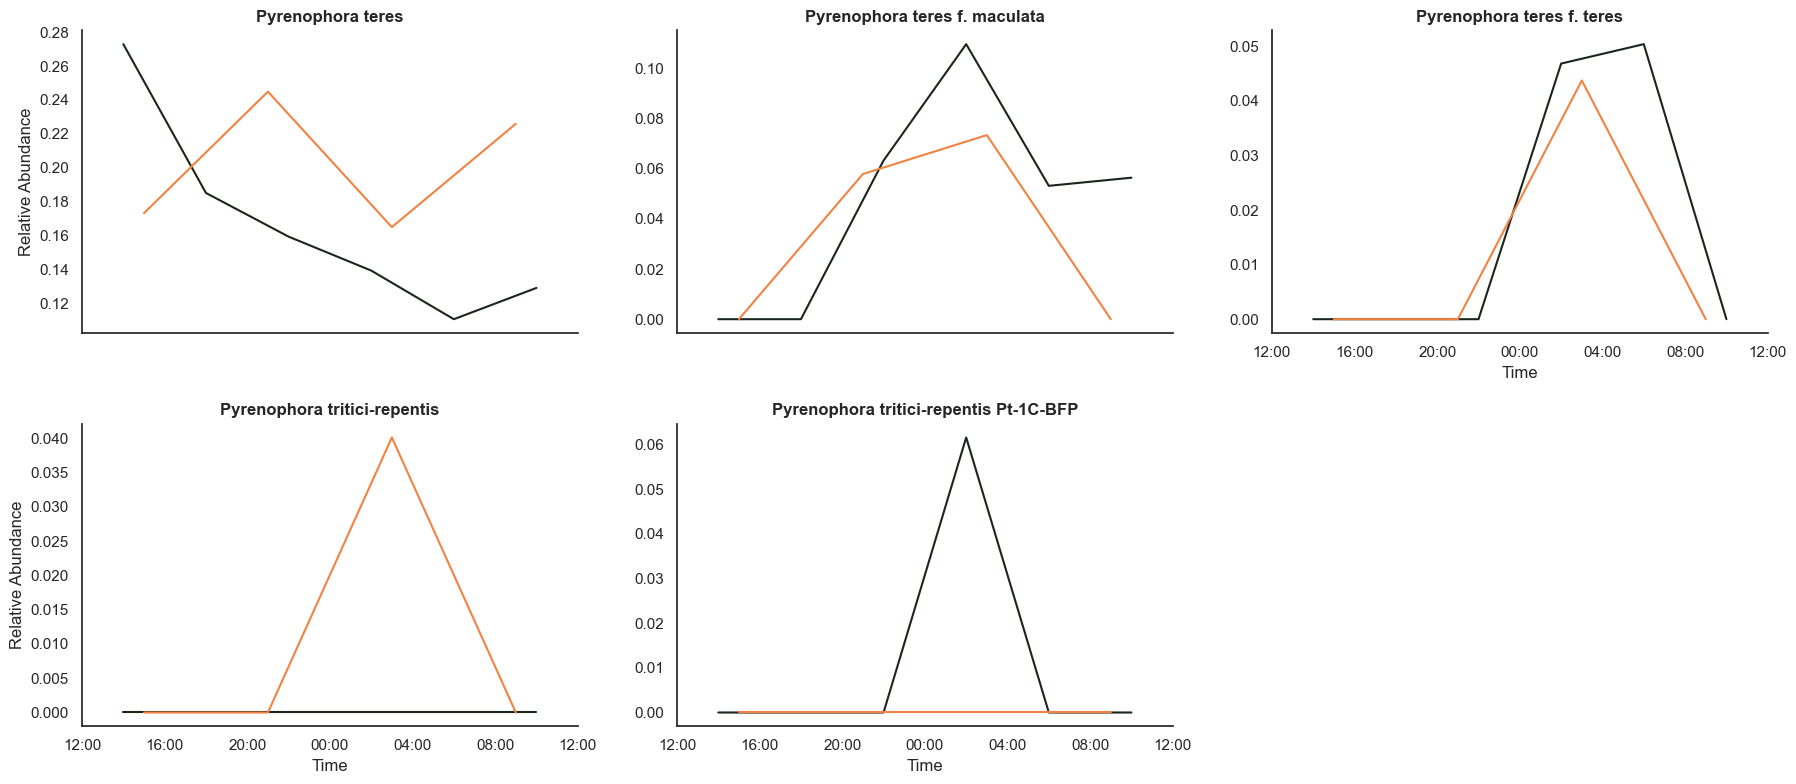

In [23]:
# Sort species alphabetically
sorted_species = pyre['Taxon'].sort_values().unique()

# Get the time range of your data
min_time = alternaria_data['Start'].min()
max_time = alternaria_data['End'].max()

# Create a FacetGrid with scatter plots for points and line plots to connect them, faceted by species / Genus
g = sns.FacetGrid(
    pyre,
    col="Taxon",
    col_wrap=3,
    col_order=sorted_species,
    sharey=False, 
    height = 4,
    aspect = 1.5,
)

# Create line plots within each facet (connecting lines)
g.map_dataframe(
    sns.lineplot,
    x="Mid",
    y="rel_abundance",
    hue="Time_hrs",
    palette={4: "#19261C", 6: "#F28241"},  # Specify hex codes for Time_hrs
    legend=False,  # Hide the legend for the line plot
    # err_style="bars" #If you want bars rather than faded sections
)

# Set x-axis properties for each subplot
g.set_axis_labels("Time", "Relative Abundance")
g.set_titles("{col_name}", fontweight = 'heavy', fontsize = 50)  # Set titles based on species

# Set x-axis properties for all subplots
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(HourLocator(interval=4))   # Set 2-hourly intervals
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Format x-axis to show hours and minutes
    ax.set_xlim([min_time, max_time])                     # Set x-axis limits from min_time to max_time

# Adjust space between plots
g.figure.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust the width and height space between subplots

plt.figsize=(15, 10)

# Genus level graph of MARTi data

#### Filtering

Looked into filtering to samples which contain more than one replicates, but this removes some Genera that are present only once but at 0.1% rel abundance

In [21]:
# Count unique samples per Genus
genus_sample_counts = fungi_data.groupby('Genus')['Sample'].nunique()

# Filter out genera with only one sample occurrence
valid_genus = genus_sample_counts[genus_sample_counts > 1].index.tolist()
print(len(valid_genus))

# Filter data for valid genera
filtered_gen_data = fungi_data[fungi_data['Genus'].isin(valid_genus)]

## Look at relative abundance of genera I am removing

invalid_genus = genus_sample_counts[genus_sample_counts == 1].index.tolist()

removed_genus_data = fungi_data[fungi_data['Genus'].isin(invalid_genus)]
removed_genus_relative_abundance = removed_genus_data.groupby('Genus')['rel_abundance'].mean()
print(removed_genus_relative_abundance)

16
Genus
Didymella        0.153232
Macroventuria    0.151355
Name: rel_abundance, dtype: float64


Lack of error bars seem to suggest each taxa was only identified in one sample, instead I am going to select the Genera which have at least one sample >0.1 rel abundance and then plot all the data from that sample. Filtering from above was removing all the repeats of the samples as they were rpesent at <0.1.

This second filtering step is what i will present as it is more accurate to the data,


In [22]:
fungi_genus_data = read_lin_meta[
    read_lin_meta["Phylum"].isin(fungi_phyla) &
    read_lin_meta["Time_hrs"].isin([4, 6]) &
    (read_lin_meta["Species"] != "Unassigned")
]

# Filter the data to include genus with at least one repeat having rel_abundance > 0.1
#This means all the other data from that genus is retained but not looking at genera which are never present at any higher level
fungi_genus_filter = fungi_genus_data.groupby("Genus").filter(lambda x: x["rel_abundance"].max() > 0.1)

#Filter the data to remove read count = 0
fungi_genus_filter = fungi_genus_filter[
    fungi_genus_filter['read count'] != 0
]

## Older code for graphs I don't like so much

Option to comment out diff parts depending on what i want - not going to mess with this section for now. 

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

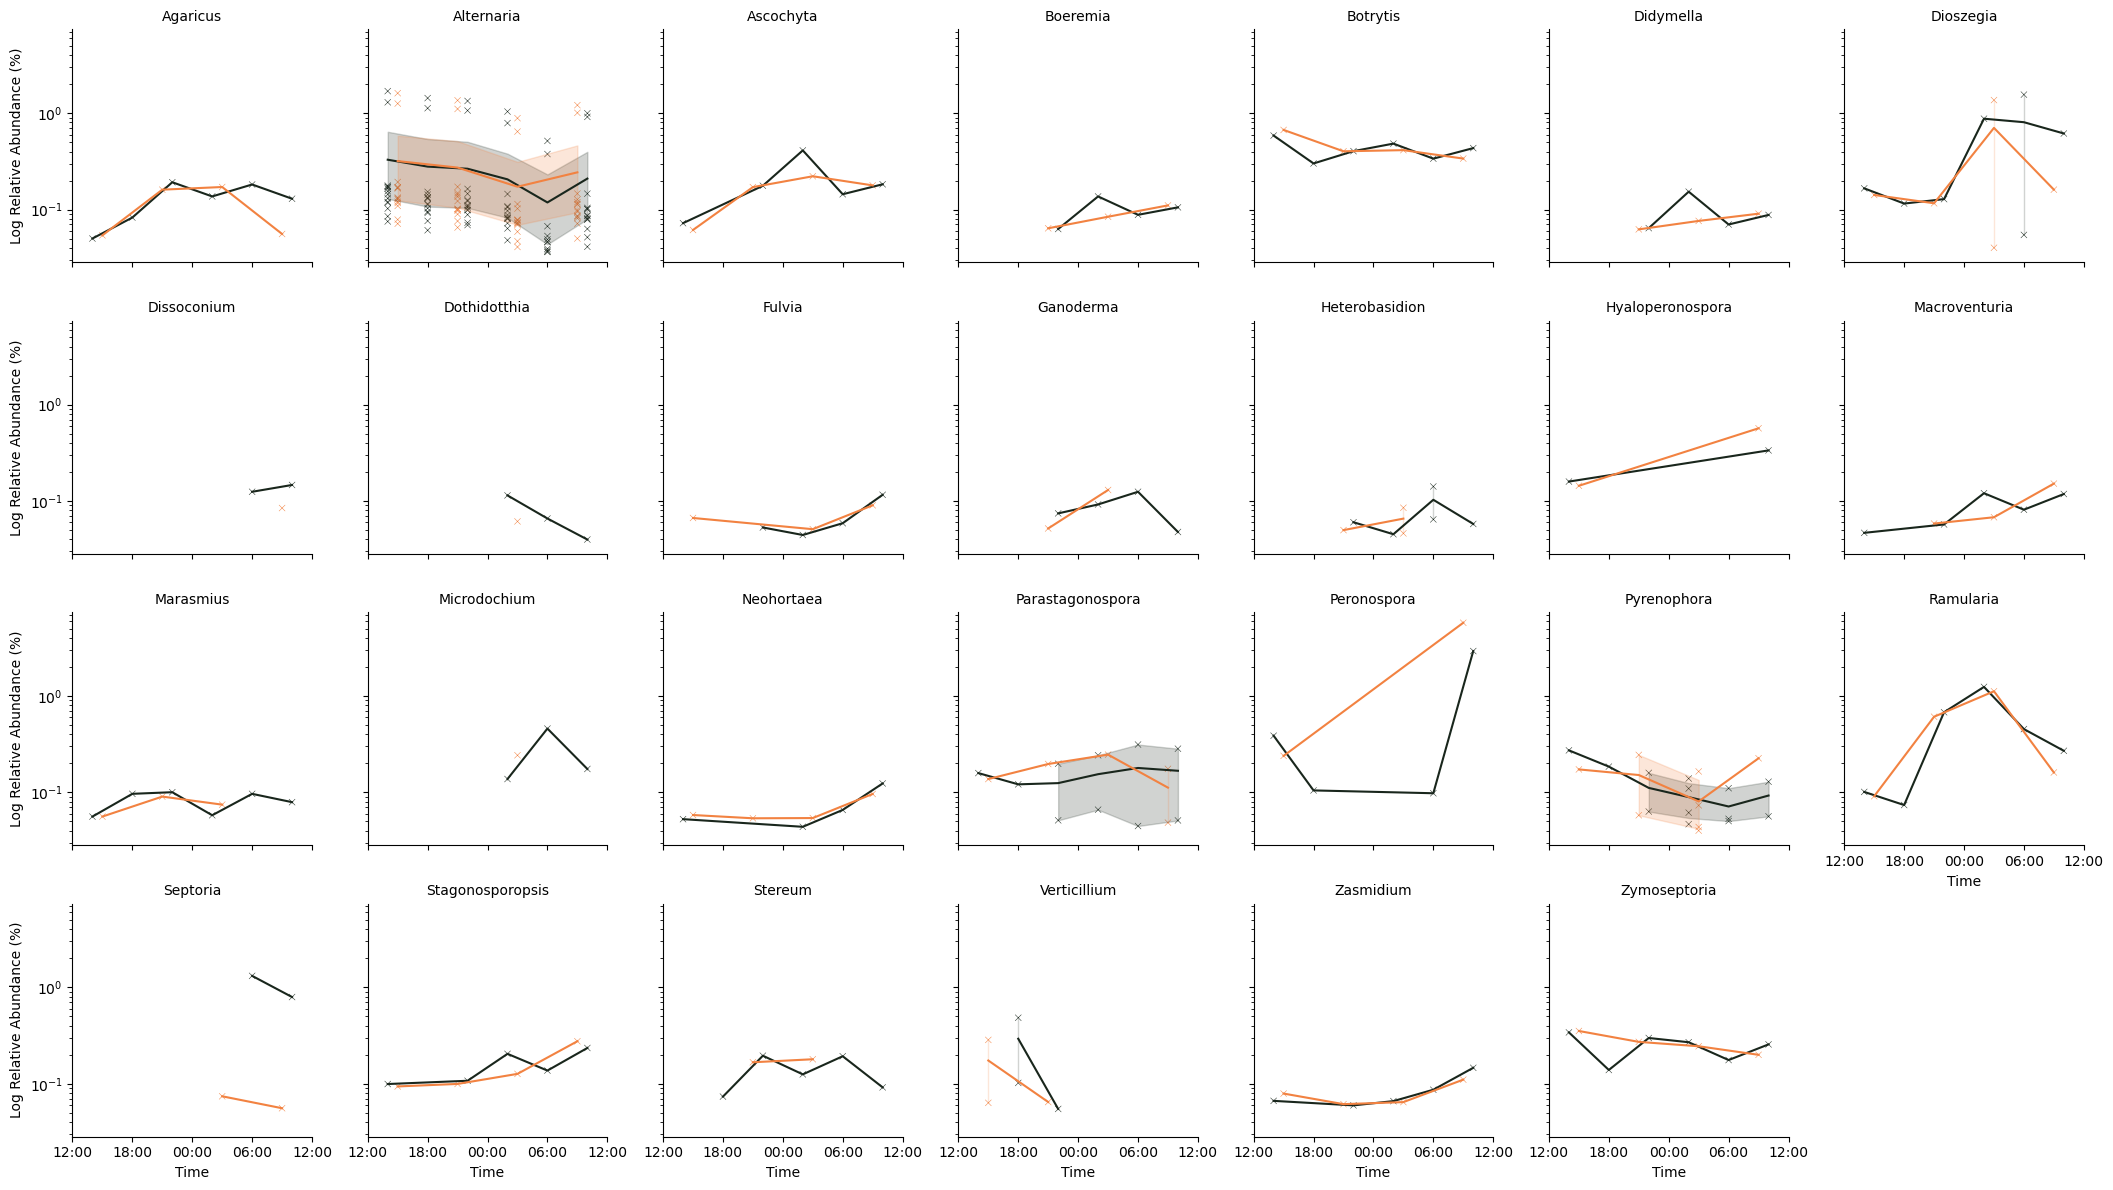

In [23]:
# Sort species alphabetically
sorted_genus = fungi_genus_filter['Genus'].sort_values().unique()

# Get the time range of your data
min_time = fungi_genus_filter['Start'].min()
max_time = fungi_genus_filter['End'].max()

# Create a FacetGrid with scatter plots for points and line plots to connect them, faceted by species
g = sns.FacetGrid(
    fungi_genus_filter,
    col="Genus",
    col_wrap=7,
    col_order=sorted_genus,
    # sharey=False, #comment if you want them to have same axis
)

#Create scatter plots within each facet (points)
g.map_dataframe(
    sns.scatterplot,
    x="Mid",
    y="rel_abundance", #change as needed
    hue="Time_hrs",
    palette={4: "#19261C", 6: "#F28241"},  # Specify hex codes for Time_hrs
    marker='x',  # Set marker as 'o' (circle)
    s=20,  # Adjust marker size as needed 
)

# Create line plots within each facet (connecting lines)
g.map_dataframe(
    sns.lineplot,
    x="Mid",
    y="rel_abundance",
    hue="Time_hrs",
    palette={4: "#19261C", 6: "#F28241"},  # Specify hex codes for Time_hrs
)

# Set x-axis labels for each subplot
g.set_axis_labels("Time", "Log Relative Abundance (%)")
g.set_titles("{col_name}")  # Set titles based on genus

# Set y-axis scale to logarithmic for scatter plots
for ax in g.axes.flat:
    ax.set_yscale('log')

# Set x-axis properties for all subplots
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(HourLocator(interval=6))  # Set intervals
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Format x-axis to show hours and minutes
    # ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Set x-axis limits from min_time to max_time
    ax.set_xlim([min_time, max_time])


# Save the FacetGrid plot as a PDF
plt.savefig('Graphs/Genus_4_6_line.pdf')


### relative change 

This code calculates relative change from the initial value, I don't actually think that is what I want so won't be plotting this. I think it would be better to plot relative change from the proceeding value which is a more complicated calculation. i also don't think it's any more helpful than what i currently have.

In [24]:
# Group by 'Genus' and 'Time_hrs', and find the start time and abundance for each group
grouped_data = fungi_genus_filter.groupby(['Genus', 'Time_hrs']).agg({'Start': 'min', 'rel_abundance': 'first'}).reset_index()

# Merge the grouped data back to the original DataFrame
fungi_genus_filter = pd.merge(fungi_genus_filter, grouped_data.rename(columns={'Start': 'start_time', 'rel_abundance': 'start_abundance'}),
              on=['Genus', 'Time_hrs'], how='left')

# Calculate the relative change
fungi_genus_filter['rel_change'] = ((
    fungi_genus_filter['rel_abundance'] - fungi_genus_filter['start_abundance'])/
      fungi_genus_filter['start_abundance']) * 100


# Heatmap

### Species 
Plotting a heatmap of relative abundance - use this data to plot all species

In [28]:
# Specify the columns you want to keep
columns_to_keep = ['Taxon', 'NCBI ID', 'Species','Sample', 'Time_hrs', 'Start', 'End', 'rel_abundance', 'read count']

# Use loc to select the specified columns
heatmap_data_sp = read_lin_meta.loc[:, columns_to_keep]

#Filter out 24 and 12 hr samples
heatmap_data_sp  = heatmap_data_sp[
    heatmap_data_sp["Time_hrs"].isin([4, 6]) &
    (heatmap_data_sp["Species"] != "Unassigned") &
    (heatmap_data_sp["rel_abundance"] > 0.15) #filtering out lower abundance species
]

Code can be altered to plot just fungal/all species. For poster want all species

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Text(0.5, 1.0, 'Relative Abundance of Species in Each Sample (log)')

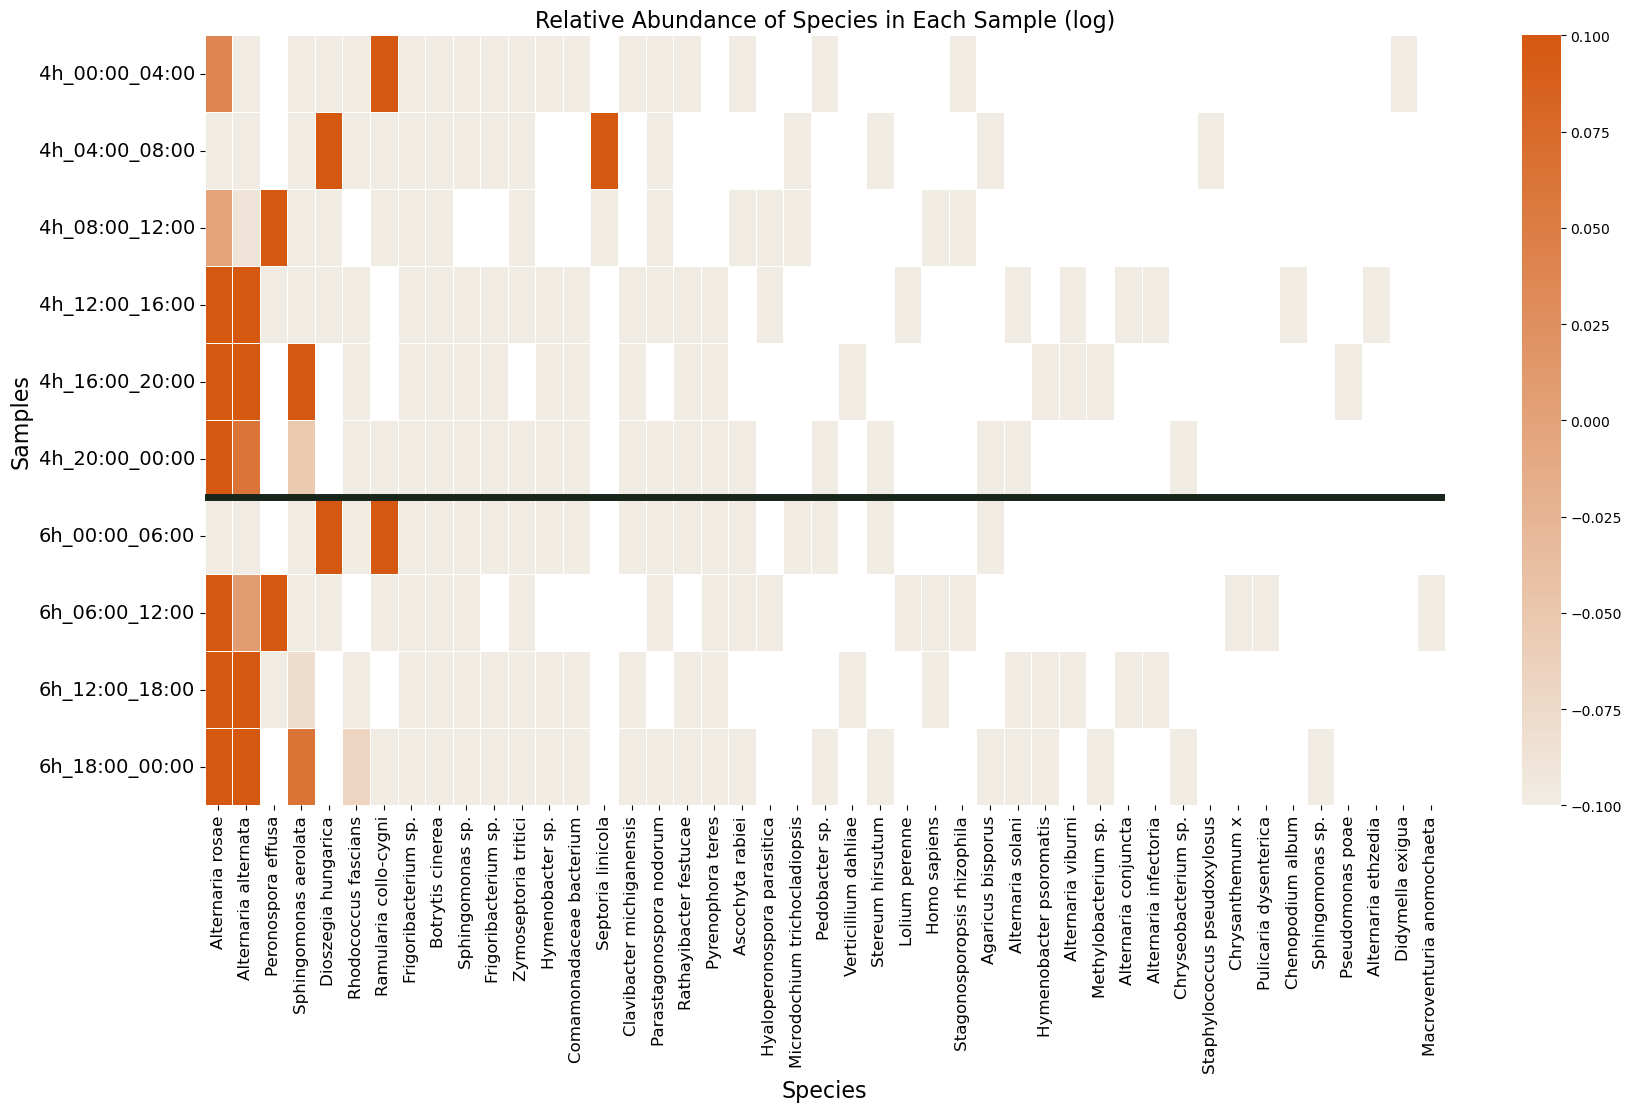

In [29]:
from matplotlib.colors import LinearSegmentedColormap


# Pivot the data - use this line for all species
heatmap_data_sp_pivot = heatmap_data_sp.pivot_table(index='Sample', columns='Species', values='rel_abundance', fill_value=0)

#To use just fungi data
# heatmap_data_sp_pivot = fungi_data.pivot_table(index='Sample', columns='Species', values='rel_abundance', fill_value=0)

sorted_species = heatmap_data_sp_pivot.mean().sort_values(ascending=False).index

# Reindex the columns of the heatmap based on sorted species
heatmap_data_sorted = heatmap_data_sp_pivot.reindex(columns=sorted_species)

# Log-transform the data for better visualization
log_data = np.log(heatmap_data_sorted)

# Define your hex color codes
start_color = '#F1ECE3' #light colour
end_color = "#D55810" #dark colour

# Convert hex colors to RGB tuples
start_rgb = tuple(int(start_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
end_rgb = tuple(int(end_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))

# Create a color map with a smooth transition between the two colors
cmap_custom = LinearSegmentedColormap.from_list('custom', [start_rgb, end_rgb])

### To plot
plt.figure(figsize=(20, 10))

ax = sns.heatmap(
            log_data,
            cmap=cmap_custom,
            linewidths=.7,
            )


# axis labels
ax.set_xlabel("Species", fontsize=16)
ax.set_ylabel("Samples", fontsize=16)

# Increase the font size of the axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

#Only printing first two strings of species------
# Get the current x-axis tick labels
x_labels = ax.get_xticklabels()
# Extract the first two strings from each label
new_x_labels = [x_label.get_text().split()[0] + ' ' + x_label.get_text().split()[1] for x_label in x_labels]
# Set the modified tick labels
ax.set_xticklabels(new_x_labels, rotation=90)

# Add a horizontal line to create a gap
ax.axhline(y=6, color='#18251B', linewidth=5)


plt.title("Relative Abundance of Species in Each Sample (log)", fontsize=16)

# Save the plot as an SVG file
# plt.savefig('Graphs/heatmap_rel_abundance_4_6.svg', format='svg')


### Genus

Looks the same as species graph - so no benefit

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Text(0.5, 1.0, 'Relative Abundance of Genera in Each Sample (log)')

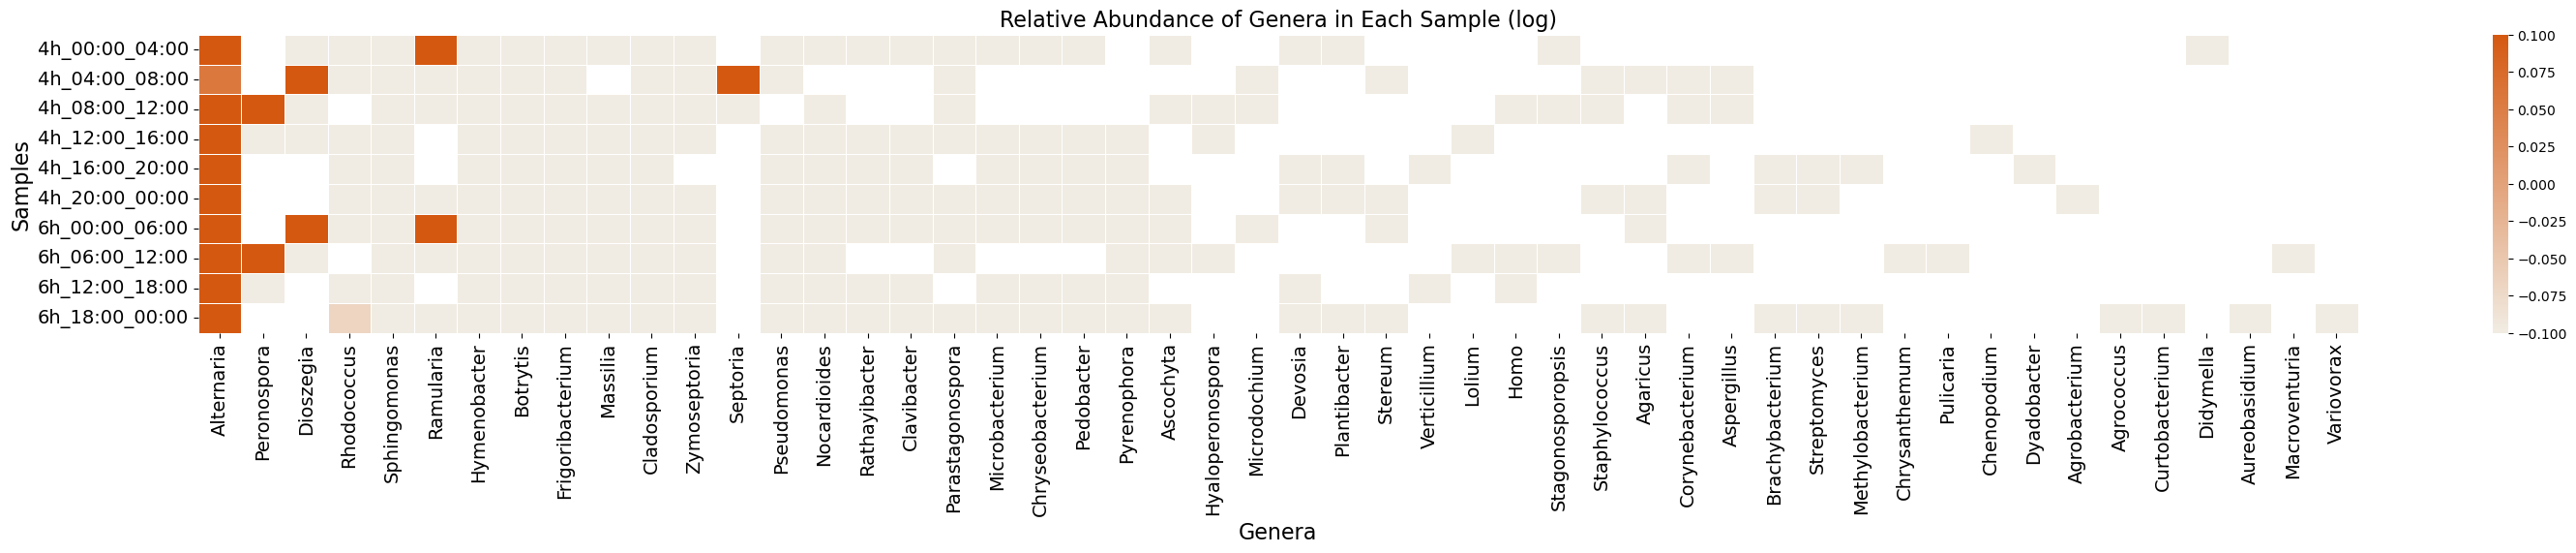

In [30]:
from matplotlib.colors import LinearSegmentedColormap

# Specify the columns you want to keep
columns_to_keep = ['Taxon', 'NCBI ID', 'Genus','Sample', 'Time_hrs', 'Start', 'End', 'rel_abundance', 'read count']

# Use loc to select the specified columns
heatmap_data_ge = read_lin_meta.loc[:, columns_to_keep]

#Filter out 24 and 12 hr samples
heatmap_data_ge  = heatmap_data_ge[
    heatmap_data_ge["Time_hrs"].isin([4, 6]) &
    (heatmap_data_ge["Genus"] != "Unassigned") &
    (heatmap_data_ge["rel_abundance"] > 0.15) #filtering out lower abundance species
]

# Pivot the data
heatmap_data_ge_pivot = heatmap_data_ge.pivot_table(index='Sample', columns='Genus', values='rel_abundance', fill_value=0)

# Sort species based on total relative abundance
sorted_genus = heatmap_data_ge_pivot.mean().sort_values(ascending=False).index

# Reindex the columns of the heatmap based on sorted species
heatmap_data_sorted_ge = heatmap_data_ge_pivot.reindex(columns=sorted_genus)

# Log-transform the data for better visualization
log_data = np.log(heatmap_data_sorted_ge)

# Define your hex color codes
start_color = '#F1ECE3' #light colour
end_color = "#D55810" #dark colour

# Convert hex colors to RGB tuples
start_rgb = tuple(int(start_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
end_rgb = tuple(int(end_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))

# Create a color map with a smooth transition between the two colors
cmap_custom = LinearSegmentedColormap.from_list('custom', [start_rgb, end_rgb])

### To plot
plt.figure(figsize=(36, 4))

ax = sns.heatmap(
            log_data,
            cmap=cmap_custom,
            linewidths=.6,
            )


# axis labels
ax.set_xlabel("Genera", fontsize=16)
ax.set_ylabel("Samples", fontsize=16)

# Increase the font size of the axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

plt.title("Relative Abundance of Genera in Each Sample (log)", fontsize=16)

## presence / absence

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94065/4097534783.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  presence_absence_data = presence_absence_data.applymap(lambda x: 1 if x > 0 else 0)


Text(0.5, 1.0, 'Presence/Absence of Species in Each Sample')

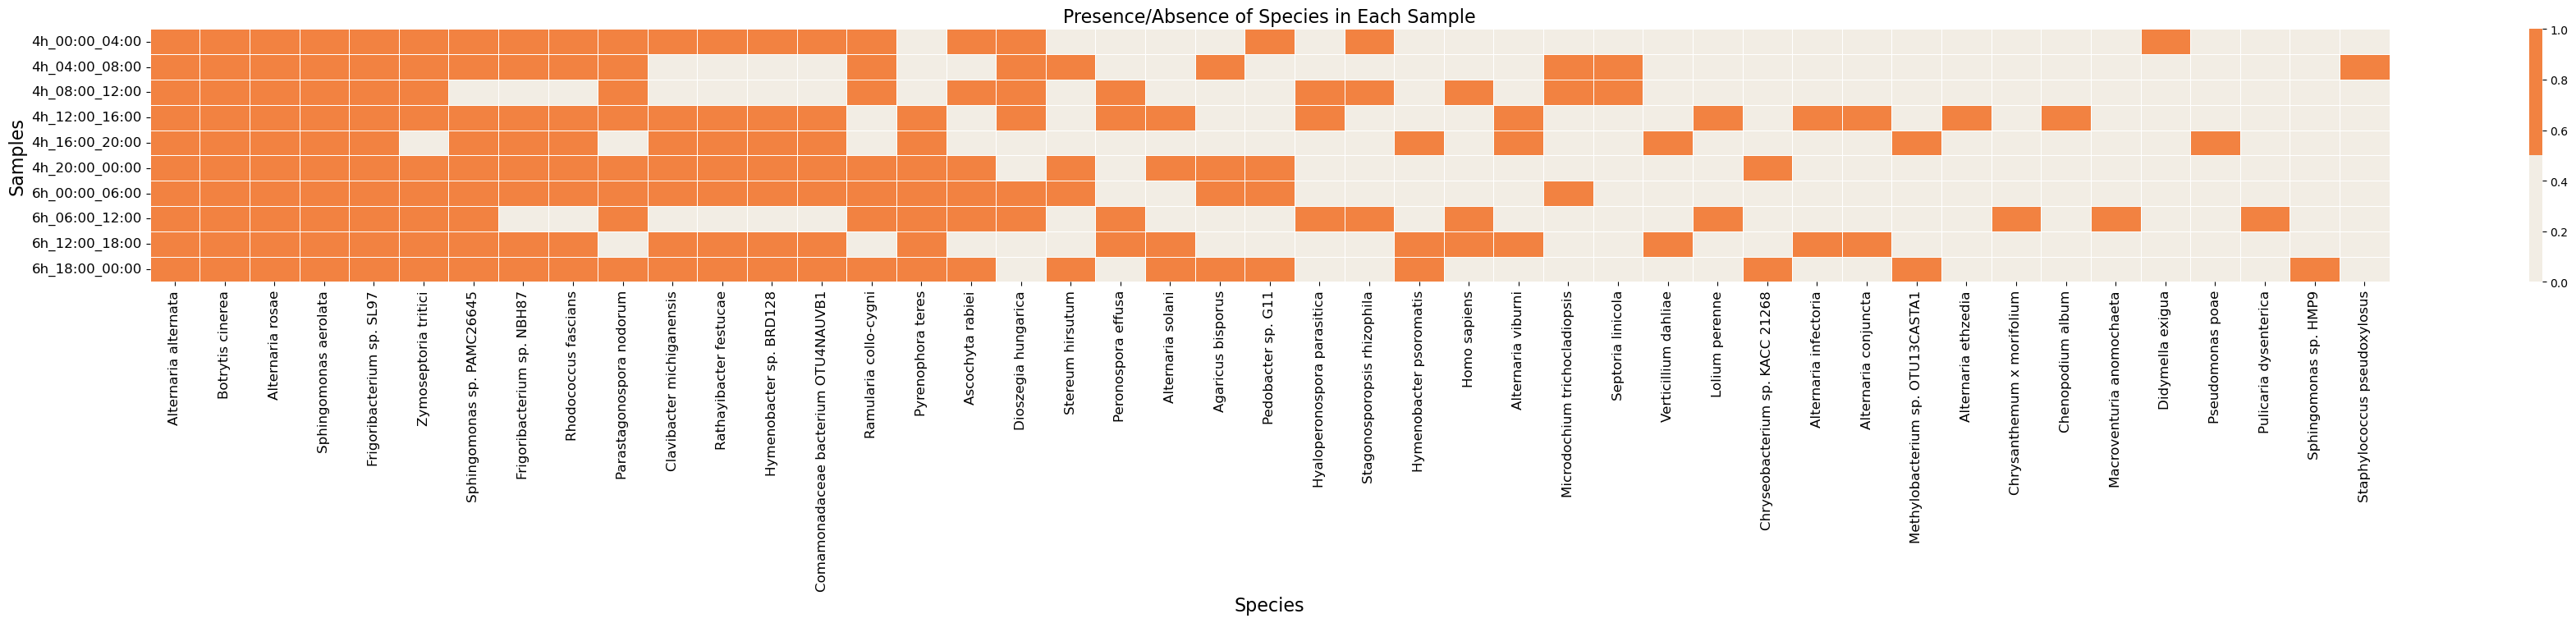

In [31]:


# Create a binary presence/absence DataFrame with 'Time_hrs'
presence_absence_data = heatmap_data_sp.pivot_table(index=['Sample'], columns='Species', values='rel_abundance', fill_value=0)
presence_absence_data = presence_absence_data.applymap(lambda x: 1 if x > 0 else 0)

# Calculate the total presence for each species
total_presence = presence_absence_data.sum(axis=0)

# Filter out species with sum 0
presence_absence_data_filtered = presence_absence_data.loc[:, total_presence[total_presence > 0].index]

# Calculate the total presence again but now just for species > 0
total_presence_non_zero = presence_absence_data_filtered.sum(axis=0)

# Sort species based on total presence
sorted_species = total_presence_non_zero.sort_values(ascending=False).index

# Reorder the columns based on sorted species
presence_absence_data_sorted = presence_absence_data[sorted_species]


### To plot
plt.figure(figsize=(44, 4))

# Specify hex codes for presence (orange) and absence (beige)
cmap_colors = ["#f2ede4", "#f28241"]

ax = sns.heatmap(
            presence_absence_data_sorted,
            cmap=cmap_colors,
            linewidths=.5,
            )


# axis labels
ax.set_xlabel("Species", fontsize=16)
ax.set_ylabel("Samples", fontsize=16)

# Increase the font size of the axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.title("Presence/Absence of Species in Each Sample", fontsize=16)


/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94065/1065593869.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  presence_absence_data = presence_absence_data.applymap(lambda x: 1 if x > 0 else 0)


Text(0.5, 1.0, 'Presence/Absence of Species in Each Sample')

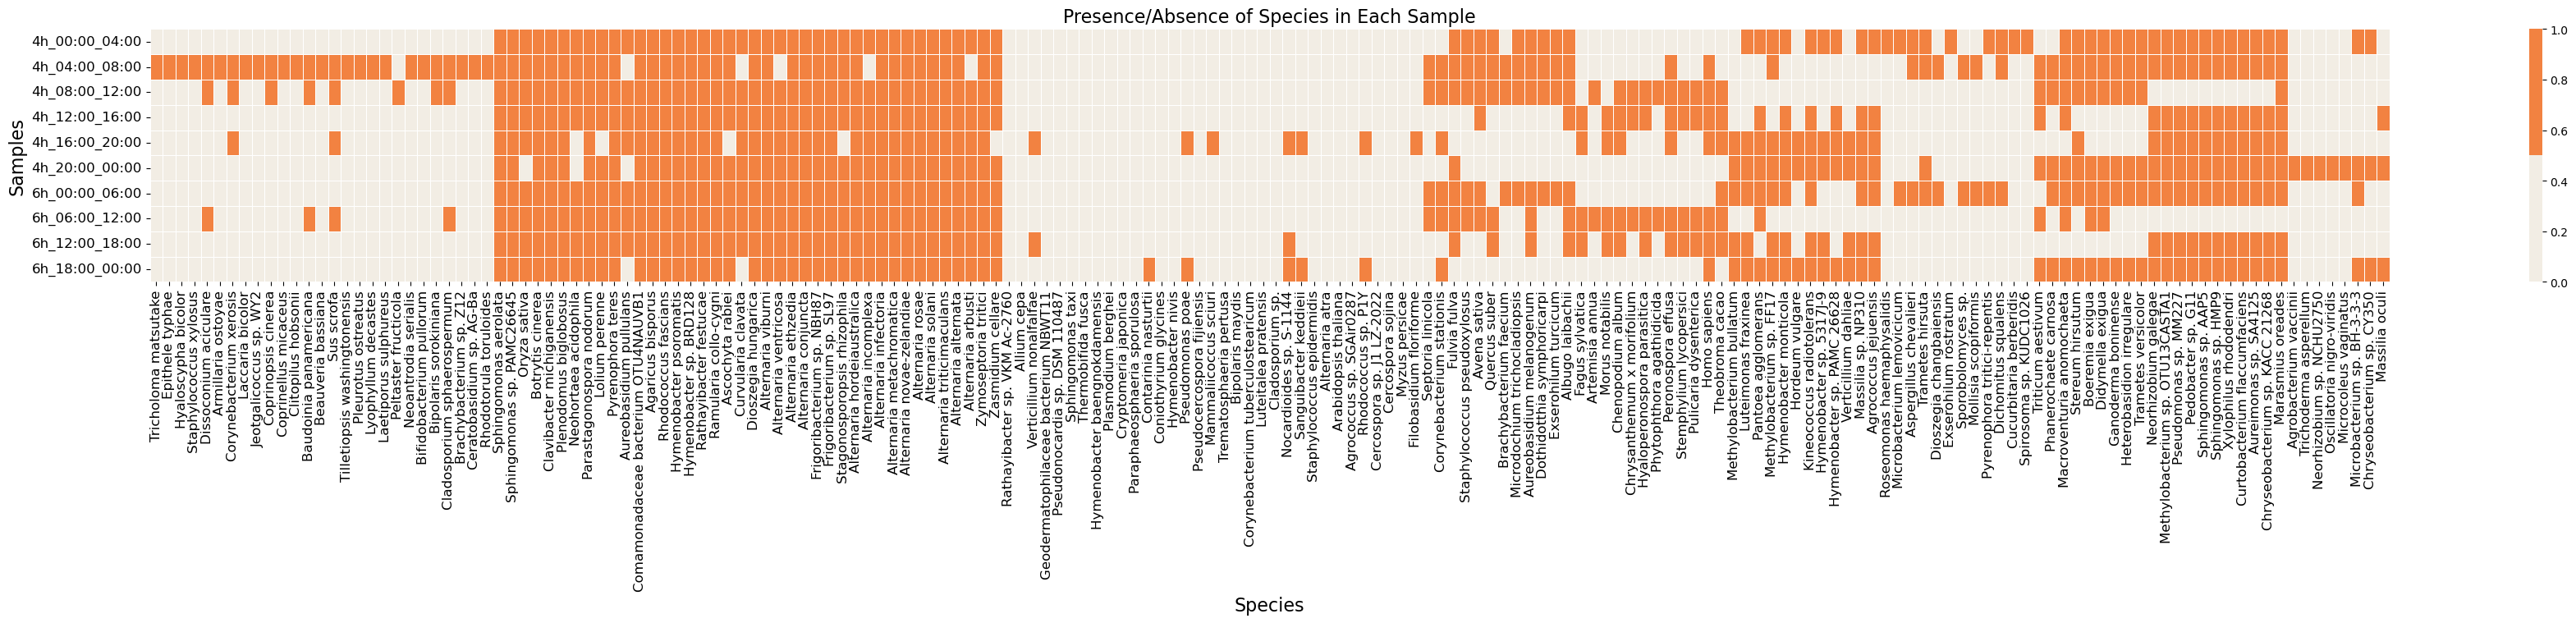

In [32]:


# Specify the columns you want to keep
columns_to_keep = ['Taxon', 'NCBI ID', 'Species','Sample', 'Time_hrs', 'Start', 'End', 'rel_abundance']

# Use loc to select the specified columns
heatmap_data = read_lin_meta.loc[:, columns_to_keep]

#Filter out 24 and 12 hr samples
heatmap_data = heatmap_data[
    heatmap_data["Time_hrs"].isin([4, 6]) &
    (heatmap_data["Species"] != "Unassigned")
]

# Pivot the data
heatmap_data_pivot = heatmap_data.pivot_table(index='Sample', columns='Species', values='rel_abundance', fill_value=0)

# Create a binary presence/absence DataFrame with 'Time_hrs'
presence_absence_data = heatmap_data.pivot_table(index=['Sample'], columns='Species', values='rel_abundance', fill_value=0)
presence_absence_data = presence_absence_data.applymap(lambda x: 1 if x > 0 else 0)

#trying a different clustering approach

clustering = AgglomerativeClustering(n_clusters=10, linkage='ward') #selected based on silhouette score
sample_clusters = clustering.fit_predict(presence_absence_data.T)
sorted_samples = presence_absence_data.columns[np.argsort(sample_clusters)]
presence_absence_data_sorted = presence_absence_data[sorted_samples]



### To plot
plt.figure(figsize=(44, 4))

# Specify hex codes for presence (orange) and absence (beige)
cmap_colors = ["#f2ede4", "#f28241"]

ax = sns.heatmap(presence_absence_data_sorted,
            cmap=cmap_colors,
            linewidths=.5,
            )


# axis labels
ax.set_xlabel("Species", fontsize=16)
ax.set_ylabel("Samples", fontsize=16)

# Increase the font size of the axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.title("Presence/Absence of Species in Each Sample", fontsize=16)


The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

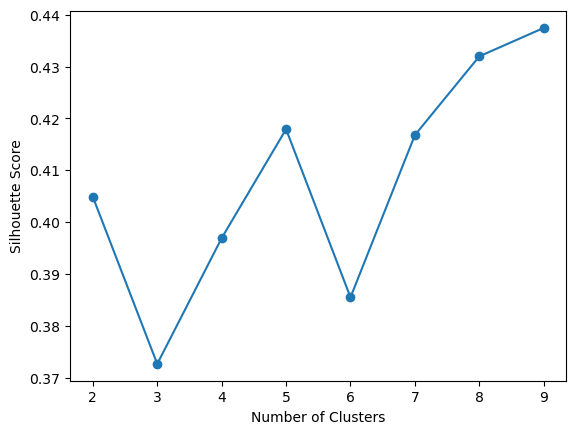

In [33]:
# Import the required module
from sklearn.metrics import silhouette_score

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Iterate over different numbers of clusters
for n_clusters in range(2, 10):
    # Create an instance of AgglomerativeClustering with specified number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters , linkage='ward')
    
    # Fit the clustering model and obtain the predicted labels
    labels = clustering.fit_predict(presence_absence_data.T)
    
    # Calculate the silhouette score for the predicted labels
    score = silhouette_score(presence_absence_data.T, labels)
    
    # Append the silhouette score to the list
    silhouette_scores.append(score)

# Plot the silhouette scores against the number of clusters
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()